## Capstone Project for Sun Jae Lim
---
**Welcome!**
This notebook is my Capstone Project for The Applied Data Science course on Coursera.

The focus will be: **Determining an Ideal Korean Restaurant Location in Chicago, Illinois**

### 1. Introduction / Business Problem
-------

Restaurants are popular establishments which serve multiple functions. They act as meeting spots, landmarks, introductions to new cultures and cuisines, and provide nourishment. In addition, the industry itself has an upward trend in growth and continues to flourish. 
The National Restaurant Association indicates a projected restaurant industry revenue of nearly 899 billion for 2020, which is a 36 billion increase compared to the industry revenue from 2019 (National Restaurant Association). 

With growth projections seemingly positive for the future, the health of the industry seems robust. Two of the most important factors for establishing a restaurant are location and population.

Our focus will be on setting up a **Korean** restaurant in the city of Chicago, Illinois. Chicago is the third largest city in the United States with over 7,000 restaurants as of 2010 (Chicago.gov). The city represents a ripe opportunity for new restauranteurs or franchise owners to leave their mark and expand their business into a densely populated area. I will be using the term "Korean" restaurant as a catch-all for restaurants focused on serving Korean food, but not limiting this to strictly traditional Korean food.

The project will examine neighborhood populations and nearby venues for each neighborhood and determine which spot would be ideal for setting up an Asian restaurant.


### 2. Data and Preparing the Data
-------
#### 2.1 Community Areas and Demographics

A list of neighborhoods and associated community areas will be obtained from the Wikipedia page titled ‘List of neighborhoods in Chicago’. The website indicates Chicago neighborhoods have historically changed over time, so the neighborhoods will be grouped into their respective community areas. Defined community areas are not used by residents and may contain several neighborhoods, but their boundaries do not change which allows for comparisons over time (Community areas). 

For community area population data, a CSV table from July 2020 posted on the CMAP Data Hub site maintained by the Illinois government will be imported into our notebook. The data contains various fields, but we will be focusing on fields pertaining to community area age groups and total population from the 2014 to 2018 community survey. All other fields will be dropped. Comparisons between 

#### 2.2 Location Data
Foursquare API will be utilized in order to obtain relevant data on venues near the community areas. 


**Summary**

* Neighborhood data will be acquired using pandas from the following Wikipedia page: [Chicago Neighborhoods](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago). 
* Population data for the community areas will be obtained from the Illinois [CMAP Data Hub](https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCAProfiles20142018.csv)
* **[Geopy](https://geopy.readthedocs.io/en/stable/#)** will be used to extract coordinates for each neighborhood.
* **[Foursquare API](https://developer.foursquare.com/places)** will be used to collect latitude and longitude values for venues near each of our neighborhoods for mapping. 
* Bar charts will be used to compare neighborhood statistics against eachother, due to neighborhoods being categorical.
* K-means clustering will be used to investigate patterns in similar neighborhoods. The resulting data will be mapped using matplotlib.
* Libraries used, and previously mentioned, will be sourced from pandas, numpy, scikitlearn, matplotlib, and geopy.
* Tables will be presented for any miscellaneous data which is not visualized.

#### 2.3 Gathering Data
##### Importing the required libraries
We will begin by importing all relevant libraries and setting up our credentials for the Foursquare API.

In [1]:
#import libraries we will be using
import pandas as pd
import numpy as np

#import requests for Foursquare
import requests

#import our visualization tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans #We will use this for clustering

!pip install folium
import folium

#import geopy to obtain coordinates
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "coursera_agent_slim")

#We will be using Foursquare, so we will define our credentials
CLIENT_ID = 'TCER0LFUIQJDBLBIHUBKWL3YEAEXZECJPUQEUQ5TLCOVYTEU'
CLIENT_SECRET = 'E3Z4PYK3SGTYNEWJBMFZBDGCEKXKPRMUYZNRLFLHTARHEWHH'
VERSION = '20180605'

     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011


##### Extracting Community Area and Neighborhood Data from Wikipedia
Data will be extracted from the Wikipedia page on Chicago neighborhoods and grouped.
Normally we would use neighborhood data for analysis; however Chicago has a history of shifting neighborhood identities.
We will instead focus on the 77 community areas, which have defined borders and are used for statistical purposes.

In [2]:
#create a URL reference for the Chicago neighborhood wiki page and scrape the data
chicago_wiki = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'
chicago_convert = pd.read_html(chicago_wiki)
chicago_df_setup = chicago_convert[0]

#Create a dataframe from the wikipedia data
df_chicago = pd.DataFrame(chicago_df_setup[['Neighborhood','Community area']])
df_chicago.rename(columns={"Community area":"CommunityArea"}, inplace=True)

#rename certain community areas
# Austin, Humboldt Park to Austin; Avondale, Irving Park to Avondale; Chatham, Roseland to Chatham; and Lakeview to Lake View
replacements = df_chicago['CommunityArea']
chicago_replacements = replacements.replace({
'Austin, Humboldt Park':'Austin', 
'Avondale, Irving Park':'Avondale',
'Chatham, Roseland':'Chatham',
'Lakeview':'Lake View',
'West Town, Logan Square':'West Town'})
df_replacements = pd.DataFrame(chicago_replacements)

In [3]:
#replace the original df_chicago['CommunityArea'] column with the new one
df_chicago['CommunityArea'] = df_replacements['CommunityArea']

In [5]:
#Change our data frame to encompass unique community areas and group neighborhoods
df_chicago_ca = df_chicago['Neighborhood'].groupby(df_chicago['CommunityArea']).unique()
df_chicago_grouped = pd.DataFrame(df_chicago_ca).reset_index()
df_chicago_grouped.head(5)

,CommunityArea,Neighborhood
0,Albany Park,"[Albany Park, Mayfair, North Mayfair, Ravenswo..."
1,Archer Heights,[Archer Heights]
2,Armour Square,"[Armour Square, Chinatown, Wentworth Gardens]"
3,Ashburn,"[Ashburn, Ashburn Estates, Beverly View, Crest..."
4,Auburn Gresham,"[Auburn Gresham, Gresham]"


In [6]:
#Remove the brackets from out Neighborhoods
df_chicago_grouped['Neighborhood'] = df_chicago_grouped['Neighborhood'].astype('str') 
df_chicago_grouped['Neighborhood'] = df_chicago_grouped['Neighborhood'].str.strip('[]')
df_chicago_grouped.head()

,CommunityArea,Neighborhood
0,Albany Park,'Albany Park' 'Mayfair' 'North Mayfair' 'Raven...
1,Archer Heights,'Archer Heights'
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens'
3,Ashburn,'Ashburn' 'Ashburn Estates' 'Beverly View' 'Cr...
4,Auburn Gresham,'Auburn Gresham' 'Gresham'


Population values will be used to compare community areas from the 2000 to 2010 census, as well as from a 2014 to 2018 population survey. Given that the data is outdated, we will assume the population and age data are roughly the same as the figures from the 2014 to 2018 survey. 

The population data will be used as a rough guideline for comparing which community areas have historically been home to more people over the past two decades.

In [7]:
#Extract data from the Chicago Community Area csv table from the Illinois government website
chicago_community_data = 'https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCAProfiles20142018.csv'
df_community_data_raw = pd.read_csv(chicago_community_data)

In [8]:
#Examine the field names
print(df_community_data_raw.columns)

Index(['GEOG', '2000_POP', '2010_POP', 'TOT_POP', 'UND19', 'A20_34', 'A35_49',
       'A50_64', 'A65_74', 'A75_84',
       ...
       '2000_ASSOC', '2000_BACH', '2000_GRAD_PROF', '2000_POP_25OV',
       'HT_Cost_Typical', 'HT_Cost_Mod', 'H_Cost_Typical', 'H_Cost_Mod',
       'T_Cost_Typical', 'T_Cost_Mod'],
      dtype='object', length=221)


In [9]:
#We will be using the most recent population data, age ranges, and racial groups
df_community_data_extracted = df_community_data_raw[['GEOG','TOT_POP','UND19','A20_34','A35_49','A50_64','A65_74', 'A75_84','OV85','MED_AGE']]
df_community_data_extracted.head()

,GEOG,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
0,Albany Park,50342.99998,12924.999990,12891.999990,11619.999990,8083.999996,2716.999999,1491.999999,613.000000,34.300953
1,Archer Heights,13055.08151,4180.292247,2753.618290,2815.956263,1672.978132,985.051690,400.184891,247.000000,32.654702
2,Armour Square,13779.11840,2542.408010,2788.930936,2297.106212,2520.154383,1922.259432,1163.746373,544.513059,45.738479
3,Ashburn,43985.99999,12981.000000,8464.999998,9192.999998,8529.999996,3057.000000,1147.000000,613.000000,35.901153
4,Auburn Gresham,45271.00001,11183.000000,8665.000001,7891.000000,9595.000003,3860.000001,3204.000000,873.000000,40.780428


In [10]:
#Round the floating values for the raw population data and rename the GEOG and TOT_POP columns
df_community_data_extracted = df_community_data_extracted.round(0) #round the values to get rid of long floating numbers
df_community_data = df_community_data_extracted.rename(columns={"GEOG":"CommunityArea","TOT_POP":"Population"})
df_community_data.head(10)

,CommunityArea,Population,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
0,Albany Park,50343.0,12925.0,12892.0,11620.0,8084.0,2717.0,1492.0,613.0,34.0
1,Archer Heights,13055.0,4180.0,2754.0,2816.0,1673.0,985.0,400.0,247.0,33.0
2,Armour Square,13779.0,2542.0,2789.0,2297.0,2520.0,1922.0,1164.0,545.0,46.0
3,Ashburn,43986.0,12981.0,8465.0,9193.0,8530.0,3057.0,1147.0,613.0,36.0
4,Auburn Gresham,45271.0,11183.0,8665.0,7891.0,9595.0,3860.0,3204.0,873.0,41.0
5,Austin,94762.0,25491.0,21226.0,17324.0,17887.0,7822.0,3920.0,1092.0,36.0
6,Avalon Park,9738.0,2218.0,1547.0,1593.0,2229.0,958.0,890.0,304.0,45.0
7,Avondale,37909.0,8749.0,12371.0,8156.0,4963.0,2283.0,979.0,408.0,33.0
8,Belmont Cragin,80648.0,24495.0,17002.0,18381.0,13769.0,4477.0,1913.0,611.0,34.0
9,Beverly,20437.0,5158.0,2830.0,4144.0,4992.0,2102.0,862.0,349.0,43.0


We will use Geopy to obtain the coordinates for our community areas. After obtaining the coordinates, the latitude and longitude values will be placed into a dataframe next to their respective community areas.

In [11]:
#create empty lists for latitude and longitude data
columns_df = ['CommunityArea','Latitude','Longitude']
df_coordinates = pd.DataFrame(columns = columns_df) 

#Obtain the names of the community areas and move them into the new dataframe
df_coordinates['CommunityArea']=df_chicago_grouped['CommunityArea']

#Obtain an array of community area names
locations = df_coordinates['CommunityArea'].values

#Define our latitude and longitude lists
latitude_ca = []
longitude_ca = []

In [12]:
#View our community areas
locations

array(['Albany Park', 'Archer Heights', 'Armour Square', 'Ashburn',
       'Auburn Gresham', 'Austin', 'Avalon Park', 'Avondale',
       'Belmont Cragin', 'Beverly', 'Bridgeport', 'Brighton Park',
       'Burnside', 'Calumet Heights', 'Chatham', 'Chicago Lawn',
       'Clearing', 'Douglas', 'Dunning', 'East Garfield Park',
       'East Side', 'Edgewater', 'Edison Park', 'Englewood',
       'Forest Glen', 'Fuller Park', 'Gage Park', 'Garfield Ridge',
       'Grand Boulevard', 'Greater Grand Crossing', 'Hegewisch',
       'Hermosa', 'Humboldt Park', 'Hyde Park', 'Irving Park',
       'Jefferson Park', 'Kenwood', 'Lake View', 'Lincoln Park',
       'Lincoln Square', 'Logan Square', 'Lower West Side',
       'McKinley Park', 'Montclare', 'Morgan Park', 'Mount Greenwood',
       'Near North Side', 'Near South Side', 'Near West Side', 'New City',
       'North Center', 'North Lawndale', 'North Park', 'Norwood Park',
       "O'Hare", 'Oakland', 'Portage Park', 'Pullman', 'Riverdale',
       '

In [13]:
#create a loop to obtain all coordinate values for our 77 community areas
for z in locations:
    try:
        query_ll = "{}, Chicago, Illinois"
        location = geolocator.geocode(query_ll.format(z))
        latitude_ca.append(location.latitude)
        longitude_ca.append(location.longitude)
        query_result = "{}, latitude {}, longitude {}"
        print(query_result.format(z, location.latitude, location.longitude))
    except AttributeError:
        latitude_ca.append(0)
        longitude_ca.append(0)
        query_fail = "{} has no location."
        print(query_fail.format(z))

Albany Park, latitude 41.9719367, longitude -87.7161739
Archer Heights, latitude 41.8114215, longitude -87.7261651
Armour Square, latitude 41.8400333, longitude -87.633107
Ashburn, latitude 41.7475332, longitude -87.7111628
Auburn Gresham, latitude 41.74338725, longitude -87.6560415931265
Austin, latitude 41.8878759, longitude -87.7648508
Avalon Park, latitude 41.7450346, longitude -87.5886584
Avondale, latitude 41.9389208, longitude -87.711168
Belmont Cragin, latitude 41.9316983, longitude -87.7686699
Beverly, latitude 41.7181532, longitude -87.6717674
Bridgeport, latitude 41.8379385, longitude -87.651028
Brighton Park, latitude 41.8189217, longitude -87.6989421
Burnside, latitude 41.7300345, longitude -87.596714
Calumet Heights, latitude 41.7300347, longitude -87.5792134
Chatham, latitude 41.7411454, longitude -87.6125481
Chicago Lawn, latitude 41.7750332, longitude -87.6964408
Clearing, latitude 41.780588, longitude -87.7733881
Douglas, latitude 41.8348565, longitude -87.6179536
Dun

In [14]:
#Add the coordinates to our df_coordinates dataframe
df_coordinates['Latitude']=latitude_ca
df_coordinates['Longitude']=longitude_ca

In [15]:
#view the coordinates dataframe
df_coordinates

,CommunityArea,Latitude,Longitude
0,Albany Park,41.971937,-87.716174
1,Archer Heights,41.811422,-87.726165
2,Armour Square,41.840033,-87.633107
3,Ashburn,41.747533,-87.711163
4,Auburn Gresham,41.743387,-87.656042
5,Austin,41.887876,-87.764851
6,Avalon Park,41.745035,-87.588658
7,Avondale,41.938921,-87.711168
8,Belmont Cragin,41.931698,-87.768670
9,Beverly,41.718153,-87.671767


### 3. Methodology
---------

Different community areas were first examined according to their populations and age groups. Given that each community area contained several neighborhoods and held varied population compositions, an analysis of the top community areas in terms of total population vs non-senior population was also conducted. The main visualization techniques used involved bar graphs, both horizontal and stacked variants. This allowed for a quick visual examination and recognition of basic features from the dataset. 

The second comparison was performed by using one-hot encoding to preprocess Foursquare API data. By using one-hot encoding, we can find averages for each of the venue locations frequented by the population and order them by the most popular to least popular. By doing so, we can then accurately use K-means clustering to group similar areas together according to popular venues. 

After K-means clustering, we can investigate individual clusters to spot any patterns or similarities. Adjusting the k value to obtain a stronger separation will lead to more accurate clustering.

Because the values are more categorical, the 'elbow' method was not used to find the optimal K value.

#### 3.1 Comparing by Population
Population is one of the largest factors of business for restaurants. A large population may indicate a larger potential customer base. 
The first analysis began with taking our population data, ordering community areas by population and viewing the top ten most populated community areas.

In [28]:
#We will examine the top 10 community areas according to the following: age groups, median age (youngest to oldest), and overall population
df_population = df_community_data.sort_values(by=['Population'], ascending=False)
df_population_top10 = df_population[:10]
df_population_top10

,CommunityArea,Population,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
37,Lake View,100547.0,12125.0,49269.0,20067.0,11077.0,4798.0,2342.0,869.0,31.0
5,Austin,94762.0,25491.0,21226.0,17324.0,17887.0,7822.0,3920.0,1092.0,36.0
46,Near North Side,89995.0,7989.0,37224.0,15675.0,14851.0,8927.0,4136.0,1193.0,35.0
75,West Town,84255.0,13212.0,38188.0,19224.0,8688.0,2995.0,1480.0,468.0,32.0
8,Belmont Cragin,80648.0,24495.0,17002.0,18381.0,13769.0,4477.0,1913.0,611.0,34.0
74,West Ridge,77212.0,21420.0,16735.0,14840.0,14012.0,5913.0,2929.0,1363.0,35.0
63,South Lawndale,74943.0,23798.0,20142.0,15112.0,10241.0,3412.0,1740.0,498.0,30.0
40,Logan Square,72724.0,14180.0,28051.0,16508.0,8825.0,3146.0,1548.0,466.0,32.0
38,Lincoln Park,68697.0,11928.0,30454.0,12008.0,8222.0,3855.0,1712.0,518.0,30.0
56,Portage Park,64954.0,15354.0,13894.0,14046.0,13644.0,4325.0,2504.0,1188.0,38.0


<function matplotlib.pyplot.show(*args, **kw)>

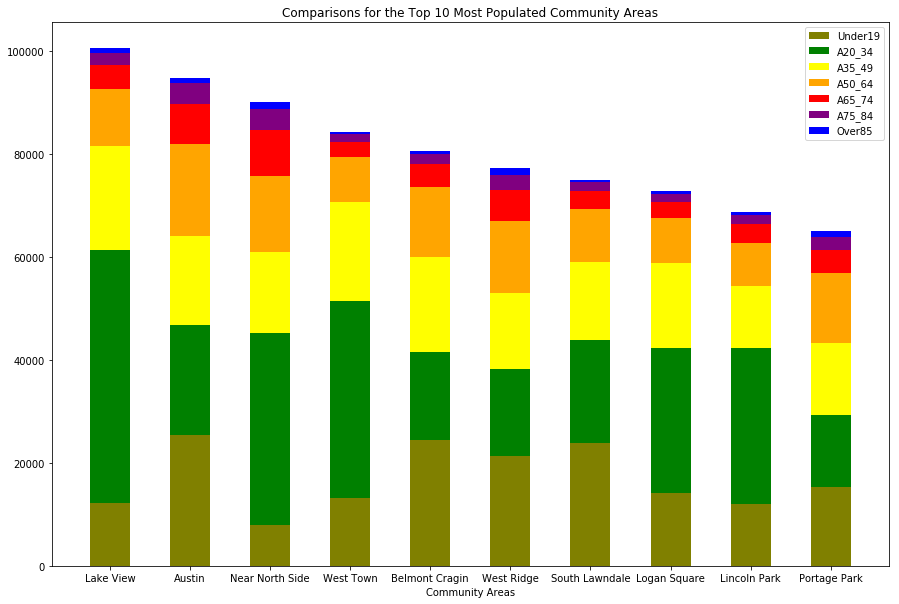

In [29]:
#Let's examine what the top ten most populated community areas look like
Under19 = df_population_top10['UND19'].values.tolist()
Age20_34 = df_population_top10['A20_34'].values.tolist()
Age35_49 = df_population_top10['A35_49'].values.tolist()
Age50_64 = df_population_top10['A50_64'].values.tolist()
Age65_74 = df_population_top10['A65_74'].values.tolist()
Age75_84 = df_population_top10['A75_84'].values.tolist()
Over85 = df_population_top10['OV85'].values.tolist()
Communities = df_population_top10['CommunityArea'].values.tolist()

N= 10
position = np.arange(N)
barnames = Communities
barwidth = 0.5

#create stacked heights for our bars
stack1 = np.add(Under19, Age20_34).tolist()
stack2 = np.add(stack1, Age35_49).tolist()
stack3 = np.add(stack2, Age50_64).tolist()
stack4 = np.add(stack3, Age65_74).tolist()
stack5 = np.add(stack4, Age75_84).tolist()

#Set figure size
fig =  plt.figure(figsize=(15, 10))

#create our bars
plt.bar(position, Under19, color='Olive', width=barwidth, label = "Under19")
plt.bar(position, Age20_34, bottom=Under19, color='Green', width=barwidth, label = "A20_34")
plt.bar(position, Age35_49, bottom=stack1, color='Yellow', width=barwidth, label = "A35_49")
plt.bar(position, Age50_64, bottom=stack2, color='Orange', width=barwidth, label = "A50_64")
plt.bar(position, Age65_74, bottom=stack3, color='Red', width=barwidth, label = "A65_74")
plt.bar(position, Age75_84, bottom=stack4, color='Purple', width=barwidth, label = "A75_84")
plt.bar(position, Over85, bottom=stack5, color='Blue', width=barwidth, label = "Over85")

#Axis labeling
plt.xticks(position, barnames)
plt.xlabel('Community Areas')
plt.title('Comparisons for the Top 10 Most Populated Community Areas')
plt.legend(loc = "upper right")
plt.show

In order to more closely examine our top ten most populated community areas, we visually split each populace into a stacked bar graph. The most populated area is on the the far left and the least populated area is on the right. 
Colors become darker as the age group becomes older. Knowing the legend, we can instantly visualize the rough breakdowns of our areas.

We know our top ten most populated areas, but will our results change by focusing on only the younger population? 
The assumption will be that anyone below the age considered "senior", which is around 50 years or older, will be counted as being "young". The population of each age group of 49 years or younger was added together, with respect to their community area. The sum for each community area was arranged in descending order to obtain the top 10 community areas with the highest population count for non-senior individuals.

In [16]:
#Let's see which community areas have the top 10 largest populations for ages 49 or younger. 
#Define the columns to target for our loop
UND19_Count = df_community_data['UND19'].values.tolist()
Age20_34_Count = df_community_data['A20_34'].values.tolist()
Age35_49_Count = df_community_data['A35_49'].values.tolist()
AgeBelow50_List = []

#Run a loop to obtain the sum count of younger people in each community area
for x, y, z in zip(UND19_Count, Age20_34_Count, Age35_49_Count):
    entry = x + y + z
    AgeBelow50_List.append(entry)

AgeBelow50_List

[37437.0,
 9750.0,
 7628.0,
 30639.0,
 27739.0,
 64041.0,
 5358.0,
 29276.0,
 59878.0,
 12132.0,
 22641.0,
 34424.0,
 1244.0,
 6792.0,
 18175.0,
 38180.0,
 17775.0,
 14995.0,
 27527.0,
 14766.0,
 17437.0,
 37740.0,
 7720.0,
 15678.0,
 11665.0,
 1181.0,
 31147.0,
 23221.0,
 15790.0,
 20428.0,
 5626.0,
 16765.0,
 42692.0,
 19620.0,
 38225.0,
 17540.0,
 11310.0,
 81461.0,
 54390.0,
 31382.0,
 58739.0,
 24712.0,
 11431.0,
 9333.0,
 12722.0,
 12751.0,
 60888.0,
 17385.0,
 51350.0,
 29098.0,
 28270.0,
 25005.0,
 11670.0,
 21909.0,
 5236.0,
 8506.0,
 43294.0,
 4255.0,
 6112.0,
 40609.0,
 25872.0,
 19971.0,
 9697.0,
 59052.0,
 34381.0,
 28760.0,
 40719.0,
 16682.0,
 8638.0,
 14530.0,
 17679.0,
 12177.0,
 24406.0,
 17914.0,
 52995.0,
 70624.0,
 16297.0]

In [17]:
#Create a new dataframe for our younger population group
df_below50 = pd.DataFrame(columns=['CommunityArea','Below50_Sum'])

#Add the community areas to our dataframe
df_community_areas = df_community_data['CommunityArea'].values.tolist()
df_below50['CommunityArea'] = df_community_areas

#Add the sums to the dataframe
df_below50['Below50_Sum'] = AgeBelow50_List
df_below50.head()

,CommunityArea,Below50_Sum
0,Albany Park,37437.0
1,Archer Heights,9750.0
2,Armour Square,7628.0
3,Ashburn,30639.0
4,Auburn Gresham,27739.0


The sum count of the younger population for each community area is located in the Below50_Sum column. We can now arrange the values in descending order and visualize the spread with a bar graph.

In [18]:
#Let's sort by the top 10 community areas
df_below50_sorted = df_below50.sort_values(by=['Below50_Sum'], ascending=False)
df_below50_top10 = df_below50_sorted[:10]

#Let's view the dataframe
df_below50_top10

,CommunityArea,Below50_Sum
37,Lake View,81461.0
75,West Town,70624.0
5,Austin,64041.0
46,Near North Side,60888.0
8,Belmont Cragin,59878.0
63,South Lawndale,59052.0
40,Logan Square,58739.0
38,Lincoln Park,54390.0
74,West Ridge,52995.0
48,Near West Side,51350.0


Text(0.5, 1.0, 'Top 10 Community Areas with the Youngest Populations')

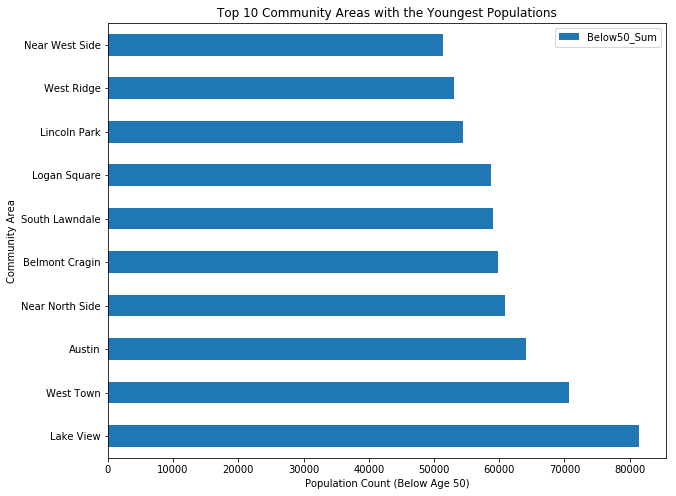

In [19]:
#Create a horizontal bar graph to visualize our data
ax = df_below50_top10.plot.barh(x='CommunityArea', y='Below50_Sum', rot=0, figsize=(10,8))
ax.set_xlabel('Population Count (Below Age 50)')
ax.set_ylabel('Community Area')
ax.set_title('Top 10 Community Areas with the Youngest Populations')

It appears the order of our community areas has changed when we focus on the younger population count. Let's plot the top 15 community areas when comparing the total younger population to the total population. We will want to expand the range to obtain a more comprehensive view of our community areas and compare.

In [20]:
#Create a dataframe to use for our comparison
df_comparison = pd.DataFrame(columns=['CommunityArea','Population','Below50_Pop'])
df_comparison['CommunityArea']= df_community_data['CommunityArea'].tolist()
df_comparison['Population']= df_community_data['Population']
df_comparison['Below50_Pop']= df_below50['Below50_Sum']
df_comparison.head(5)

,CommunityArea,Population,Below50_Pop
0,Albany Park,50343.0,37437.0
1,Archer Heights,13055.0,9750.0
2,Armour Square,13779.0,7628.0
3,Ashburn,43986.0,30639.0
4,Auburn Gresham,45271.0,27739.0


In [21]:
#Order by greatest population and take the top 15
df_comparison_sorted = df_comparison.sort_values(by=['Population'], ascending = False)
df_comparison_top15 = df_comparison_sorted[:15]
df_comparison_top15

,CommunityArea,Population,Below50_Pop
37,Lake View,100547.0,81461.0
5,Austin,94762.0,64041.0
46,Near North Side,89995.0,60888.0
75,West Town,84255.0,70624.0
8,Belmont Cragin,80648.0,59878.0
74,West Ridge,77212.0,52995.0
63,South Lawndale,74943.0,59052.0
40,Logan Square,72724.0,58739.0
38,Lincoln Park,68697.0,54390.0
56,Portage Park,64954.0,43294.0


In [22]:
#Let's set the index to the community area
df_comparison_plot = df_comparison_top15.set_index('CommunityArea')

Text(0.5, 1.0, "Total vs Below 50 Population in Chicago's Top 15 Most Populated Areas")

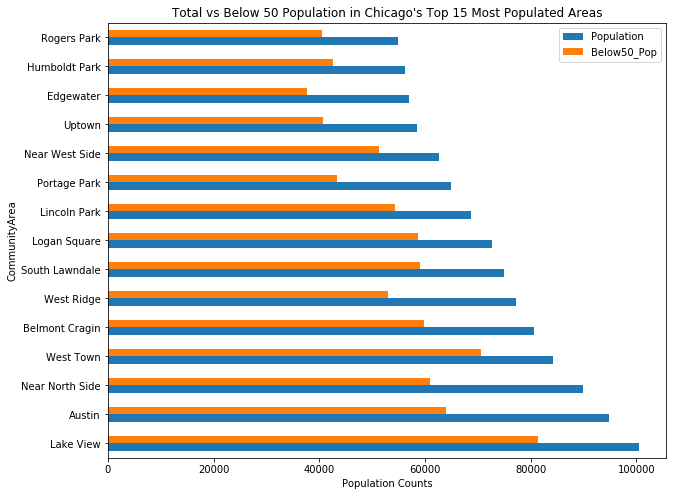

In [23]:
#Let's try graphing the plot and comparing the top 15 most populated areas with respect to their overall population count
ax2 = df_comparison_plot.plot.barh(rot=0, figsize=(10,8))
ax2.set_xlabel('Population Counts')
ax2.set_title('Total vs Below 50 Population in Chicago\'s Top 15 Most Populated Areas')

Some community areas have a smaller total population, but a larger demographic of younger residents. Let's see which community areas would be the most viable when ordered by population of residents below the age of 50.

In [24]:
#create the new dataframe and sort by descending order of younger population
df_comparison_sorted_2 = df_comparison.sort_values(by=['Below50_Pop'], ascending = False)
df_comparison_below50_top15 = df_comparison_sorted_2[:15]
df_comparison_below50_top15

,CommunityArea,Population,Below50_Pop
37,Lake View,100547.0,81461.0
75,West Town,84255.0,70624.0
5,Austin,94762.0,64041.0
46,Near North Side,89995.0,60888.0
8,Belmont Cragin,80648.0,59878.0
63,South Lawndale,74943.0,59052.0
40,Logan Square,72724.0,58739.0
38,Lincoln Park,68697.0,54390.0
74,West Ridge,77212.0,52995.0
48,Near West Side,62733.0,51350.0


In [25]:
#set the index to the community areas
df_below50 = df_comparison_below50_top15.set_index('CommunityArea')
df_below50

,Population,Below50_Pop
CommunityArea,,
Lake View,100547.0,81461.0
West Town,84255.0,70624.0
Austin,94762.0,64041.0
Near North Side,89995.0,60888.0
Belmont Cragin,80648.0,59878.0
South Lawndale,74943.0,59052.0
Logan Square,72724.0,58739.0
Lincoln Park,68697.0,54390.0
West Ridge,77212.0,52995.0


Text(0.5, 1.0, "Below 50 Age Group vs Total Population in Chicago's Top 15 Areas with the Youngest Demographic")

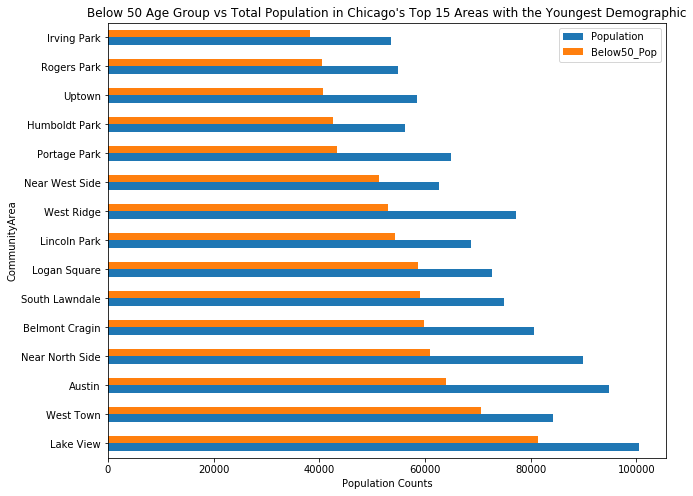

In [26]:
#Let's try graphing the plot on a horizontal bar graph
ax3 = df_below50.plot.barh(rot=0, figsize=(10,8))
ax3.set_xlabel('Population Counts')
ax3.set_title('Below 50 Age Group vs Total Population in Chicago\'s Top 15 Areas with the Youngest Demographic')

Despite the difference in total population, some of our top communities appear to have a large population count of older residents. The rankings will be reexamined in the results section.

Next, we will focus on obtaining venues from our neighborhoods using Foursquare API. 

#### 3.2 Obtaining Venues via Foursquare API

In [27]:
#We imported our credentials earlier. Let's use the Foursquare API to gather relevant venue data.
LIMIT= 100
radius = 500

#Create a function for obtaining venues
def NearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        #define the Foursquare API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Extract only the relevant venue information: name, location and categories
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], 
                             v['venue']['location']['lat'], 
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])
    
    #Create a new dataframe which includes the venue information
    df_nearbyvenues = pd.DataFrame(item for venue_list in venues_list for item in venue_list)
    df_nearbyvenues.columns = ['CommunityArea','CA_Latitude','CA_Longitude','Venue','Venue_Latitude','Venue_Longitude','Venue_Category']
    
    return(df_nearbyvenues)

In [28]:
#Obtain venue data using our function
chicago_venues = NearbyVenues(names = df_coordinates['CommunityArea'], latitudes = df_coordinates['Latitude'], longitudes = df_coordinates['Longitude'], radius = 500)

Albany Park
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Chatham
Chicago Lawn
Clearing
Douglas
Dunning
East Garfield Park
East Side
Edgewater
Edison Park
Englewood
Forest Glen
Fuller Park
Gage Park
Garfield Ridge
Grand Boulevard
Greater Grand Crossing
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Logan Square
Lower West Side
McKinley Park
Montclare
Morgan Park
Mount Greenwood
Near North Side
Near South Side
Near West Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Portage Park
Pullman
Riverdale
Rogers Park
Roseland
South Chicago
South Deering
South Lawndale
South Shore
The Loop
Uptown
Washington Heights
Washington Park
West Elsdon
West Englewood
West Garfield Park
West Lawn
West Pullman
West Ridge
West Town
Woodlawn


In [29]:
#Let's view our venue data's shape and take a glance at the values
print("The shape of chicago_venues:", chicago_venues.shape)
chicago_venues.head(15)

The shape of chicago_venues: (1553, 7)


,CommunityArea,CA_Latitude,CA_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany Park,41.971937,-87.716174,Chicago Produce,41.970553,-87.716327,Grocery Store
1,Albany Park,41.971937,-87.716174,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
2,Albany Park,41.971937,-87.716174,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,Albany Park,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Albany Park,41.971937,-87.716174,Popeyes Louisiana Kitchen,41.968756,-87.713019,Fried Chicken Joint
5,Albany Park,41.971937,-87.716174,Banpojung,41.975707,-87.715609,Korean Restaurant
6,Albany Park,41.971937,-87.716174,Markellos Baking Company,41.968602,-87.716607,Bakery
7,Albany Park,41.971937,-87.716174,Subway,41.968748,-87.712861,Sandwich Place
8,Albany Park,41.971937,-87.716174,T-Mobile,41.968751,-87.713158,Mobile Phone Shop
9,Albany Park,41.971937,-87.716174,Dunkin',41.968255,-87.712964,Donut Shop


In [30]:
#Check the number of unique venues
print("There are {} unique venue types.".format(len(chicago_venues['Venue_Category'].unique())))

#check the number of unique community areas
print("There are {} unique community areas.".format(len(chicago_venues['CommunityArea'].unique())))

There are 246 unique venue types.
There are 75 unique community areas.


In [31]:
#Create a list of values
chicago_venues_values = chicago_venues['CommunityArea'].values.tolist()

In [32]:
#Obtain value counts
chicago_venues_values_series = pd.Series(chicago_venues_values)
chicago_venues_values_series.value_counts()

The Loop              100
Logan Square           74
Lincoln Park           71
Lake View              70
Uptown                 68
North Center           66
Edgewater              55
Near South Side        54
Lower West Side        53
Lincoln Square         41
Douglas                38
Rogers Park            36
Bridgeport             35
Jefferson Park         35
West Town              34
Avondale               29
O'Hare                 29
Hyde Park              28
Edison Park            27
Near North Side        26
Near West Side         24
Kenwood                21
West Elsdon            21
McKinley Park          20
Irving Park            20
Portage Park           18
West Garfield Park     17
Forest Glen            16
Belmont Cragin         16
Englewood              15
                     ... 
Armour Square          11
Pullman                11
West Lawn              11
Chicago Lawn           11
South Shore            10
East Garfield Park     10
Beverly                10
Washington P

It looks like around 24 community areas have less than 10 venues available. The Loop has the most venues available. Given our 77 community area count from earlier, it appears some areas are missing. 

Let's discover which areas are missing.

In [33]:
#We appear to be missing some community areas. Let's double check.
community_area_list = df_coordinates['CommunityArea'].values.tolist()
#we defined the following earlier
#chicago_venues_values = chicago_venues['CommunityArea'].values.tolist()

#Create a list of missing areas from our query
missing_community_areas = [x for x in community_area_list if x not in chicago_venues_values]
print(missing_community_areas)

['Riverdale', 'South Deering']


Increasing the radius of the Foursquare API query may help us discover venues near our missing areas.

In [34]:
#extract the coordinates for our missing areas
df_missing_areas = df_coordinates.loc[df_coordinates['CommunityArea'].isin(missing_community_areas)]
df_missing_areas

,CommunityArea,Latitude,Longitude
58,Riverdale,41.667835,-87.604964
62,South Deering,41.692236,-87.571703


In [35]:
#Let's double the range of our previous query
chicago_venues_3 = NearbyVenues(names = df_missing_areas['CommunityArea'], latitudes = df_missing_areas['Latitude'], longitudes = df_missing_areas['Longitude'], radius = 1000)
chicago_venues_3

Riverdale
South Deering


,CommunityArea,CA_Latitude,CA_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Riverdale,41.667835,-87.604964,MMA Academy,41.675821,-87.602112,Martial Arts Dojo
1,Riverdale,41.667835,-87.604964,DaJelle,41.660601,-87.610474,Clothing Store
2,Riverdale,41.667835,-87.604964,Metra KYD Yard,41.671758,-87.615651,Train Station
3,South Deering,41.692236,-87.571703,Big Marsh,41.687097,-87.571038,Bike Trail
4,South Deering,41.692236,-87.571703,Republic Services Calumet Transfer Station,41.697603,-87.572223,Waste Facility
5,South Deering,41.692236,-87.571703,Park No. 564,41.685486,-87.575012,Park
6,South Deering,41.692236,-87.571703,Harborside Golf Course Hole 12 Bathroom,41.696577,-87.581540,Golf Course


Looks like increasing our radius achieved better results.
We will re-run out previous query using the new radius.

In [36]:
#Use Foursquare API to search all venues again with the doubled radius of 1000
chicago_venues_new = NearbyVenues(names = df_coordinates['CommunityArea'], latitudes = df_coordinates['Latitude'], longitudes = df_coordinates['Longitude'], radius = 1000)

#Check the number of unique venues
print("There are {} unique venue types.".format(len(chicago_venues_new['Venue_Category'].unique())))

#check the number of unique community areas
print("There are {} unique community areas.".format(len(chicago_venues_new['CommunityArea'].unique())))

Albany Park
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Chatham
Chicago Lawn
Clearing
Douglas
Dunning
East Garfield Park
East Side
Edgewater
Edison Park
Englewood
Forest Glen
Fuller Park
Gage Park
Garfield Ridge
Grand Boulevard
Greater Grand Crossing
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Logan Square
Lower West Side
McKinley Park
Montclare
Morgan Park
Mount Greenwood
Near North Side
Near South Side
Near West Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Portage Park
Pullman
Riverdale
Rogers Park
Roseland
South Chicago
South Deering
South Lawndale
South Shore
The Loop
Uptown
Washington Heights
Washington Park
West Elsdon
West Englewood
West Garfield Park
West Lawn
West Pullman
West Ridge
West Town
Woodlawn
There are 344 unique venue types.
There are 77 unique community 

In [37]:
#Create a list of new values
chicago_venues_values_new = chicago_venues_new['CommunityArea'].values.tolist()

#Obtain value counts
chicago_venues_values_series_new = pd.Series(chicago_venues_values_new)
chicago_venues_values_series_new.value_counts()

Uptown                    100
Edgewater                 100
Hyde Park                 100
Near South Side           100
The Loop                  100
West Town                 100
Lower West Side           100
Avondale                  100
Lincoln Park              100
Rogers Park               100
Lake View                 100
North Center              100
Near North Side           100
O'Hare                    100
Near West Side            100
Lincoln Square             95
Bridgeport                 81
Belmont Cragin             79
Logan Square               78
Irving Park                77
Albany Park                76
West Ridge                 71
Beverly                    69
West Elsdon                66
Dunning                    64
Portage Park               61
Humboldt Park              61
Hermosa                    60
South Shore                59
Armour Square              58
                         ... 
Garfield Ridge             33
Auburn Gresham             33
Avalon Par

It appears all community areas are now within our range. Riverdale has the lowest nearby venue count of 3, and many more areas have hit the query limit of 100.


#### 3.3 One hot encoding

In [39]:
#one hot encode for venue category
chicago_onehot = pd.get_dummies(chicago_venues_new['Venue_Category'])

In [40]:
#Let's view our onehot columns
chicago_onehot_columns = chicago_onehot.columns.tolist()
chicago_onehot_columns

['ATM',
 'Accessories Store',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'Airport Lounge',
 'Airport Service',
 'American Restaurant',
 'Amphitheater',
 'Animal Shelter',
 'Antique Shop',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auditorium',
 'Auto Dealership',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Boat Rental',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Burmese Restaurant',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'B

In [41]:
#Let's add the community areas back to the onehot dataframe
chicago_onehot['CommunityArea'] = chicago_venues_new['CommunityArea']

In [42]:
#How many community areas are present?
print('We have {} community areas'.format(len(chicago_onehot['CommunityArea'].unique())))

We have 77 community areas


In [43]:
#Moving the community areas column to the front
new_columns = chicago_onehot.columns.tolist()
revised_columns = new_columns[-1:] + new_columns[:-1]
chicago_onehot = chicago_onehot[revised_columns]
chicago_onehot.head(15)

,CommunityArea,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
#group rows by CommunityArea
chicago_onehot_grouped = chicago_onehot.groupby('CommunityArea').mean().reset_index()
chicago_onehot_grouped

,CommunityArea,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
1,Archer Heights,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.027778,0.000000,0.00
2,Armour Square,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.034483,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
3,Ashburn,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.080000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
4,Auburn Gresham,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.060606,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.030303,0.00,0.000000,0.000000,0.00
5,Austin,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.076923,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
6,Avalon Park,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.031250,0.000000,0.00
7,Avondale,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
8,Belmont Cragin,0.012658,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025316,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
9,Beverly,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.057971,0.00


From the venue examination above, the second lowest venue count was 4 for South Deering and the lowest was 2 for Riverdale.

In [45]:
#define a function to obtain the four top venues
number_of_top_venues = 4
def most_common_venues (row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

#create a new dataframe for our ordered data
chicago_top_venues = pd.DataFrame(columns = ['CommunityArea', '1st Venue', '2nd Venue', '3rd Venue', '4th Venue'])

#Add the community area column
chicago_top_venues['CommunityArea'] = chicago_onehot_grouped['CommunityArea']

#add the data
for ind in np.arange(chicago_onehot_grouped.shape[0]):
    chicago_top_venues.iloc[ind, 1:] = most_common_venues(chicago_onehot_grouped.iloc[ind, :], number_of_top_venues)

In [46]:
#Let's view the data
chicago_top_venues.head()

,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
2,Armour Square,Chinese Restaurant,Bar,Park,Pizza Place
3,Ashburn,Fast Food Restaurant,Park,Pizza Place,American Restaurant
4,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store


In [47]:
#Let's view the shape
print("The shape is:", chicago_top_venues.shape)

The shape is: (77, 5)


#### 3.4 Clustering and k-means evaluation
We will cluster our data into groups and proceed to merge it back to the main dataframe.

In [48]:
#define k clusters. Let's start with 5.
kclusters = 5
chicago_clusters = chicago_onehot_grouped.drop(['CommunityArea'], 1)
kmeans = KMeans(n_clusters = kclusters, init='k-means++',random_state=0).fit(chicago_clusters)

#check the kmean labels
kmeans.labels_

array([0, 2, 0, 3, 3, 3, 3, 0, 2, 3, 0, 2, 3, 3, 3, 3, 2, 3, 0, 3, 2, 0,
       0, 3, 0, 3, 2, 2, 3, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 2,
       3, 2, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 3, 2, 4, 2, 3, 0,
       0, 0, 3, 2, 3, 3, 2, 3, 3, 0, 0], dtype=int32)

In [49]:
#Create a copy of our chicago_top_veues dataframe for modification
chicago_venue_cluster5 = chicago_top_venues.copy(deep = True)

In [50]:
#insert the cluster data into the copied modified one hot dataframe
chicago_venue_cluster5.insert(0, 'Clusters', kmeans.labels_)
chicago_venue_cluster5.head()

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,0,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
1,2,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
2,0,Armour Square,Chinese Restaurant,Bar,Park,Pizza Place
3,3,Ashburn,Fast Food Restaurant,Park,Pizza Place,American Restaurant
4,3,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store


The clustered data is now available. Each cluster group will be examined for any immediately visible patterns or trends.

In [51]:
#Let's group by cluster type and view the data spread
df_cluster_0 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 0]
df_cluster_0

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,0,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
2,0,Armour Square,Chinese Restaurant,Bar,Park,Pizza Place
7,0,Avondale,Bar,Mexican Restaurant,Donut Shop,Park
10,0,Bridgeport,Chinese Restaurant,Pizza Place,Mexican Restaurant,Art Gallery
18,0,Dunning,Cosmetics Shop,Fast Food Restaurant,Shoe Store,Shipping Store
21,0,Edgewater,Coffee Shop,Asian Restaurant,Grocery Store,Sandwich Place
22,0,Edison Park,Bar,Park,Italian Restaurant,Spa
24,0,Forest Glen,Music Store,Filipino Restaurant,Park,Bakery
30,0,Hegewisch,Bar,Chinese Restaurant,Pet Store,Greek Restaurant
32,0,Humboldt Park,Latin American Restaurant,Bar,Sandwich Place,Liquor Store


In [52]:
#Let's view the other clusters
df_cluster_1 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 1]
df_cluster_1

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
58,1,Riverdale,Clothing Store,Train Station,Martial Arts Dojo,Yoga Studio


In [53]:
df_cluster_2 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 2]
df_cluster_2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
1,2,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
8,2,Belmont Cragin,Mexican Restaurant,Sandwich Place,Pharmacy,Latin American Restaurant
11,2,Brighton Park,Mexican Restaurant,Taco Place,Sandwich Place,Grocery Store
16,2,Clearing,Pizza Place,Park,Video Store,Playground
20,2,East Side,Mexican Restaurant,Baseball Field,Playground,Park
26,2,Gage Park,Mexican Restaurant,Grocery Store,Convenience Store,Sandwich Place
27,2,Garfield Ridge,Park,Mexican Restaurant,Discount Store,Hot Dog Joint
31,2,Hermosa,Mexican Restaurant,Grocery Store,Latin American Restaurant,Park
41,2,Lower West Side,Mexican Restaurant,Bar,Pizza Place,Latin American Restaurant
43,2,Montclare,Pizza Place,Fast Food Restaurant,Grocery Store,Mexican Restaurant


In [54]:
df_cluster_3 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 3]
df_cluster_3

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
3,3,Ashburn,Fast Food Restaurant,Park,Pizza Place,American Restaurant
4,3,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store
5,3,Austin,Grocery Store,Discount Store,Southern / Soul Food Restaurant,Fried Chicken Joint
6,3,Avalon Park,Fast Food Restaurant,Pharmacy,Grocery Store,Park
9,3,Beverly,Cosmetics Shop,Women's Store,Pizza Place,Fast Food Restaurant
12,3,Burnside,Fast Food Restaurant,Rental Car Location,Park,Dry Cleaner
13,3,Calumet Heights,Fast Food Restaurant,Pharmacy,Discount Store,Wings Joint
14,3,Chatham,Chinese Restaurant,Park,Sandwich Place,Boutique
15,3,Chicago Lawn,Discount Store,Fast Food Restaurant,Park,Cosmetics Shop
17,3,Douglas,Fast Food Restaurant,Sandwich Place,Historic Site,Fried Chicken Joint


In [55]:
df_cluster_4 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 4]
df_cluster_4

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
62,4,South Deering,Golf Course,Bike Trail,Park,Waste Facility


Some areas still seem to have large groups with mixed venues. Let's raise the cluster amount and try again. The new k value will be 10.

In [56]:
#define new k clusters. Let's try 10.
kclusters2 = 10
chicago_venue_cluster10 = chicago_top_venues.copy(deep = True)
chicago_clusters10 = chicago_onehot_grouped.drop(['CommunityArea'], 1)
kmeans2 = KMeans(n_clusters = kclusters2, init='k-means++',random_state=0).fit(chicago_clusters10)

#insert the cluster data into the modified one hot dataframe
chicago_venue_cluster10.insert(0, 'Clusters', kmeans2.labels_)
chicago_venue_cluster10.head()

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,9,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
1,9,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
2,1,Armour Square,Chinese Restaurant,Bar,Park,Pizza Place
3,4,Ashburn,Fast Food Restaurant,Park,Pizza Place,American Restaurant
4,9,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store


Once again, clusters will be separated and examined for patterns or trends.

In [58]:
#Let's view our groups
df_cluster_0_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 0]
df_cluster_0_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
67,0,Washington Heights,Ice Cream Shop,Bakery,Park,Salon / Barbershop


In [57]:
df_cluster_1_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 1]
df_cluster_1_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
2,1,Armour Square,Chinese Restaurant,Bar,Park,Pizza Place
7,1,Avondale,Bar,Mexican Restaurant,Donut Shop,Park
10,1,Bridgeport,Chinese Restaurant,Pizza Place,Mexican Restaurant,Art Gallery
20,1,East Side,Mexican Restaurant,Baseball Field,Playground,Park
21,1,Edgewater,Coffee Shop,Asian Restaurant,Grocery Store,Sandwich Place
22,1,Edison Park,Bar,Park,Italian Restaurant,Spa
30,1,Hegewisch,Bar,Chinese Restaurant,Pet Store,Greek Restaurant
32,1,Humboldt Park,Latin American Restaurant,Bar,Sandwich Place,Liquor Store
33,1,Hyde Park,Bookstore,Coffee Shop,Café,Sandwich Place
34,1,Irving Park,Bar,Sandwich Place,Coffee Shop,Donut Shop


In [59]:
df_cluster_2_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 2]
df_cluster_2_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
13,2,Calumet Heights,Fast Food Restaurant,Pharmacy,Discount Store,Wings Joint
14,2,Chatham,Chinese Restaurant,Park,Sandwich Place,Boutique
17,2,Douglas,Fast Food Restaurant,Sandwich Place,Historic Site,Fried Chicken Joint
19,2,East Garfield Park,Train Station,Food,Discount Store,Mobile Phone Shop
25,2,Fuller Park,Train Station,Baseball Field,Pizza Place,Park
28,2,Grand Boulevard,BBQ Joint,Breakfast Spot,Coffee Shop,Train Station
51,2,North Lawndale,Fast Food Restaurant,Sandwich Place,Gym / Fitness Center,Fried Chicken Joint
52,2,North Park,Bus Station,Sandwich Place,Korean Restaurant,Park
57,2,Pullman,Train Station,Park,Fast Food Restaurant,Baseball Field
60,2,Roseland,Discount Store,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant


In [60]:
df_cluster_3_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 3]
df_cluster_3_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
26,3,Gage Park,Mexican Restaurant,Grocery Store,Convenience Store,Sandwich Place
41,3,Lower West Side,Mexican Restaurant,Bar,Pizza Place,Latin American Restaurant
61,3,South Chicago,Mexican Restaurant,Discount Store,Pharmacy,American Restaurant
63,3,South Lawndale,Mexican Restaurant,Mobile Phone Shop,Park,Fast Food Restaurant
72,3,West Lawn,Mexican Restaurant,Pizza Place,Ice Cream Shop,Chinese Restaurant


In [61]:
df_cluster_4_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 4]
df_cluster_4_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
3,4,Ashburn,Fast Food Restaurant,Park,Pizza Place,American Restaurant
6,4,Avalon Park,Fast Food Restaurant,Pharmacy,Grocery Store,Park
12,4,Burnside,Fast Food Restaurant,Rental Car Location,Park,Dry Cleaner
23,4,Englewood,Fast Food Restaurant,Park,ATM,Sandwich Place
70,4,West Englewood,Cosmetics Shop,Fast Food Restaurant,Discount Store,Liquor Store
73,4,West Pullman,Fast Food Restaurant,Video Game Store,Bank,Grocery Store


In [62]:
df_cluster_5_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 5]
df_cluster_5_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
58,5,Riverdale,Clothing Store,Train Station,Martial Arts Dojo,Yoga Studio


In [63]:
df_cluster_6_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 6]
df_cluster_6_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
44,6,Morgan Park,BBQ Joint,Park,Sandwich Place,Business Service


In [64]:
df_cluster_7_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 7]
df_cluster_7_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
55,7,Oakland,Beach,BBQ Joint,Park,Coffee Shop


In [65]:
df_cluster_8_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 8]
df_cluster_8_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
62,8,South Deering,Golf Course,Bike Trail,Park,Waste Facility


In [66]:
df_cluster_9_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 9]
df_cluster_9_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,9,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
1,9,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
4,9,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store
5,9,Austin,Grocery Store,Discount Store,Southern / Soul Food Restaurant,Fried Chicken Joint
8,9,Belmont Cragin,Mexican Restaurant,Sandwich Place,Pharmacy,Latin American Restaurant
9,9,Beverly,Cosmetics Shop,Women's Store,Pizza Place,Fast Food Restaurant
11,9,Brighton Park,Mexican Restaurant,Taco Place,Sandwich Place,Grocery Store
15,9,Chicago Lawn,Discount Store,Fast Food Restaurant,Park,Cosmetics Shop
16,9,Clearing,Pizza Place,Park,Video Store,Playground
18,9,Dunning,Cosmetics Shop,Fast Food Restaurant,Shoe Store,Shipping Store


An examination of specific venues can be performed.

In [68]:
#Define a list for each of the venue columns in the cluster dataframe
mylist = ['1st Venue','2nd Venue', '3rd Venue','4th Venue']
newlist = []

#Create and run a loop for discovering areas with Korean venues
for x in mylist:
    venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains("Korean")]
    venue_y = venue['CommunityArea'].values.tolist()
    newlist.extend(venue_y)

#Remove any blank entries and brackets
modified_list = [x for x in newlist if x !=[]]

print("Community areas with Korean restaurants are: {}".format(modified_list))

Community areas with Korean restaurants are: ['North Park']


In [99]:
#Let's find areas with train, taxi or bus stations
transport_list = []
transportation = ["Train","Bus","Taxi"]

#Define a function to loop through the clustered columns
def transportloop(vehicle):
    for x in mylist:
        venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains(vehicle)]
        venue_add = venue['CommunityArea'].values.tolist()
        transport_list.extend(venue_add)

In [100]:
#Run the loop
for x in transportation:
    transportloop(x)

#Remove any blank entries and brackets
modified_list2 = [x for x in transport_list if x !=[]]

print("Community areas with train, bus or taxi stops: {}".format(', '.join(transport_list)))

Community areas with train, bus or taxi stops: East Garfield Park, Fuller Park, Pullman, West Garfield Park, Riverdale, Grand Boulevard, North Park, Morgan Park


Venues with common asian restaurants or the word 'asian' can also be discovered by examining the columns. Locations with common asian restaurants may prove to be potential candidates for a neighborhood or community area known for asian cuisine.

In [89]:
#Create a blank list
ca_asian_restaurants = []

#Create a list with common asian restaurant types or preferred search terms
sample_list = ["Chinese", "Japanese", "Vietnamese", "Asian", "Indian", "Pakistani"]

#Define a function to loop through the clustered columns
def asianfoodfinder(asianfood):
    for x in mylist:
        venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains(asianfood)]
        venue_add = venue['CommunityArea'].values.tolist()
        ca_asian_restaurants.extend(venue_add)

In [90]:
#Let's find the community areas
for x in sample_list:
    asianfoodfinder(x)

#remove duplicates
ca_asian_venues = list(dict.fromkeys(ca_asian_restaurants))

print("Community areas with sampled asian restaurants: {}".format(', '.join(ca_asian_venues)))

Community areas with sampled asian restaurants: Armour Square, Bridgeport, Chatham, Near South Side, Hegewisch, Uptown, West Lawn, Edgewater, West Ridge


In [91]:
#Let's make a combined list of our locations with the sample asian restaurants, korean restaurants, or train stations
candidates_list = modified_list + modified_list2 + ca_asian_venues
print(candidates_list)

['North Park', 'East Garfield Park', 'Fuller Park', 'Pullman', 'West Garfield Park', 'Riverdale', 'Grand Boulevard', 'North Park', 'Morgan Park', 'Armour Square', 'Bridgeport', 'Chatham', 'Near South Side', 'Hegewisch', 'Uptown', 'West Lawn', 'Edgewater', 'West Ridge']


In [73]:
#merge the original Toronto dataframe with the top venues dataframe
chicago_merged = df_chicago_grouped.join(chicago_venue_cluster10.set_index('CommunityArea'), on='CommunityArea')

#Create a dataframe of total population and coordinates
df_population_setup = df_comparison[['CommunityArea','Population']]
df_population_setup_2 = df_population_setup.join(df_coordinates.set_index('CommunityArea'), on='CommunityArea')

#Merge our dataframes into one final dataframe
chicago_final = df_population_setup_2.join(chicago_merged.set_index('CommunityArea'), on= 'CommunityArea')

#rearrange our columns
final_columns = ['CommunityArea','Neighborhood','Population', 'Clusters','Latitude','Longitude','1st Venue','2nd Venue','3rd Venue','4th Venue']

#Let's view the dataframe
chicago_final = chicago_final[final_columns]
chicago_final

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
0,Albany Park,'Albany Park' 'Mayfair' 'North Mayfair' 'Raven...,50343.0,9,41.971937,-87.716174,Mexican Restaurant,Middle Eastern Restaurant,Grocery Store,Coffee Shop
1,Archer Heights,'Archer Heights',13055.0,9,41.811422,-87.726165,Mexican Restaurant,Mobile Phone Shop,Clothing Store,Grocery Store
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens',13779.0,1,41.840033,-87.633107,Chinese Restaurant,Bar,Park,Pizza Place
3,Ashburn,'Ashburn' 'Ashburn Estates' 'Beverly View' 'Cr...,43986.0,4,41.747533,-87.711163,Fast Food Restaurant,Park,Pizza Place,American Restaurant
4,Auburn Gresham,'Auburn Gresham' 'Gresham',45271.0,9,41.743387,-87.656042,Fast Food Restaurant,Pharmacy,Currency Exchange,Discount Store
5,Austin,'Galewood' 'The Island' 'North Austin' 'South ...,94762.0,9,41.887876,-87.764851,Grocery Store,Discount Store,Southern / Soul Food Restaurant,Fried Chicken Joint
6,Avalon Park,'Avalon Park' 'Marynook' 'Stony Island Park',9738.0,4,41.745035,-87.588658,Fast Food Restaurant,Pharmacy,Grocery Store,Park
7,Avondale,'Avondale' 'Jackowo' 'Polish Village' 'Wacławowo',37909.0,1,41.938921,-87.711168,Bar,Mexican Restaurant,Donut Shop,Park
8,Belmont Cragin,'Belmont Central' 'Brickyard' 'Cragin' 'Hanson...,80648.0,9,41.931698,-87.768670,Mexican Restaurant,Sandwich Place,Pharmacy,Latin American Restaurant
9,Beverly,'Beverly' 'East Beverly' 'West Beverly',20437.0,9,41.718153,-87.671767,Cosmetics Shop,Women's Store,Pizza Place,Fast Food Restaurant


In [74]:
#Sort the final dataframe by population in descending order
chicago_final.sort_values(by=['Population'], ascending=False)

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
37,Lake View,'Boystown' 'Graceland West' 'Lake View' 'Lake ...,100547.0,1,41.947050,-87.655429,Pizza Place,General Entertainment,Gay Bar,Sports Bar
5,Austin,'Galewood' 'The Island' 'North Austin' 'South ...,94762.0,9,41.887876,-87.764851,Grocery Store,Discount Store,Southern / Soul Food Restaurant,Fried Chicken Joint
46,Near North Side,'Cabrini–Green' 'Gold Coast' 'Goose Island' 'M...,89995.0,1,41.900033,-87.634497,Steakhouse,Coffee Shop,Hotel,American Restaurant
75,West Town,'East Village' 'Noble Square' 'Polish Downtown...,84255.0,1,41.901421,-87.686166,Bar,Coffee Shop,Dive Bar,Restaurant
8,Belmont Cragin,'Belmont Central' 'Brickyard' 'Cragin' 'Hanson...,80648.0,9,41.931698,-87.768670,Mexican Restaurant,Sandwich Place,Pharmacy,Latin American Restaurant
74,West Ridge,'Nortown' 'Peterson Park' 'Rosehill' 'West Rid...,77212.0,9,42.003548,-87.696243,Indian Restaurant,Pakistani Restaurant,Grocery Store,Park
63,South Lawndale,'Little Village' 'Marshall Square' 'South Lawn...,74943.0,3,41.843644,-87.712554,Mexican Restaurant,Mobile Phone Shop,Park,Fast Food Restaurant
40,Logan Square,'Bucktown' 'Kosciuszko Park' 'Logan Square' 'P...,72724.0,1,41.928568,-87.706793,Coffee Shop,Cocktail Bar,Café,Brewery
38,Lincoln Park,'Lincoln Park' 'Old Town Triangle' 'Park West'...,68697.0,1,41.921699,-87.647832,Coffee Shop,Pizza Place,Italian Restaurant,Mexican Restaurant
56,Portage Park,'Portage Park',64954.0,1,41.957809,-87.765059,Bar,Pizza Place,Park,Gas Station


With the final dataframe, folium is used to plot locations on a map of Chicago, Illinois with each cluster group in a different color.

The map will present an aerial view representation of where the clusters are located and provide insight as to whether certain regions are more similar to others.

#### 3.5 Mapping using folium

In [75]:
#generate a new map of Chicago, Illinois

#find the average latitude and longitude value for our chicago coordinates from earlier
latitude = df_coordinates['Latitude'].mean(axis=0, skipna=True)
longitude = df_coordinates['Longitude'].mean(axis=0, skipna=True)
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#define a set of colors
x = np.arange(kclusters2)
ys= [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0,1, len(ys)))
cluster_color = [colors.rgb2hex(i) for i in colors_array]

#create markers to add to the map
for lat, lng, cluster, neighborhood, ca, pop in zip(chicago_final['Latitude'], chicago_final['Longitude'], chicago_final['Clusters'], chicago_final['Neighborhood'], chicago_final['CommunityArea'], chicago_final['Population']):
    info = 'Cluster {}, {}, {}, {} total population'.format(cluster, neighborhood, ca, pop)
    label = folium.Popup(info, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup = label, color=cluster_color[cluster-1], fill=True, fill_color=cluster_color[cluster-1], fill_opacity=0.5).add_to(cluster_map)

cluster_map

Revisiting the data obtained from filtering out areas near asian restaurants and train, bus or taxi stops from earlier may provide useful information.

In [93]:
#Create a candidates list without duplicates if needed
candidates_list_final = list(dict.fromkeys(candidates_list))

print(candidates_list_final)

['North Park', 'East Garfield Park', 'Fuller Park', 'Pullman', 'West Garfield Park', 'Riverdale', 'Grand Boulevard', 'Morgan Park', 'Armour Square', 'Bridgeport', 'Chatham', 'Near South Side', 'Hegewisch', 'Uptown', 'West Lawn', 'Edgewater', 'West Ridge']


In [96]:
#Let's check our candidates list and compare possible locations
df_candidates_extracted = chicago_final.loc[chicago_final['CommunityArea'].str.contains("North Park|East Garfield Park|Fuller Park|Pullman|West Garfield Park|Riverdale|Grand Boulevard|Morgan Park|Armour Square|Bridgeport|Chatham|Near South Side|Hegewisch|Uptown|West Lawn|Edgewater|West Ridge")]

df_candidates_extracted

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens',13779.0,1,41.840033,-87.633107,Chinese Restaurant,Bar,Park,Pizza Place
10,Bridgeport,'Bridgeport',33828.0,1,41.837938,-87.651028,Chinese Restaurant,Pizza Place,Mexican Restaurant,Art Gallery
14,Chatham,'Chatham' 'East Chatham' 'West Chatham' 'West ...,30700.0,2,41.741145,-87.612548,Chinese Restaurant,Park,Sandwich Place,Boutique
19,East Garfield Park,'East Garfield Park' 'Fifth City',19731.0,2,41.880866,-87.702833,Train Station,Food,Discount Store,Mobile Phone Shop
21,Edgewater,'Andersonville' 'Edgewater' 'Edgewater Beach' ...,57022.0,1,41.983369,-87.663952,Coffee Shop,Asian Restaurant,Grocery Store,Sandwich Place
25,Fuller Park,'Fuller Park',2399.0,2,41.818089,-87.632551,Train Station,Baseball Field,Pizza Place,Park
28,Grand Boulevard,'Grand Boulevard' 'Legends South (Robert Taylo...,22784.0,2,41.813923,-87.617272,BBQ Joint,Breakfast Spot,Coffee Shop,Train Station
30,Hegewisch,'Hegewisch',9241.0,1,41.653646,-87.546988,Bar,Chinese Restaurant,Pet Store,Greek Restaurant
44,Morgan Park,'Beverly Woods' 'Kennedy Park' 'Morgan Park' '...,21694.0,6,41.690312,-87.666716,BBQ Joint,Park,Sandwich Place,Business Service
47,Near South Side,'Central Station' 'Dearborn Park' 'Museum Camp...,24343.0,1,41.856700,-87.624774,Chinese Restaurant,Pizza Place,Hotel,Park


In [97]:
#Order by population and graph
df_candidates_ordered = df_candidates_extracted.sort_values(by=['Population'], ascending=False)

df_candidates_ordered

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
74,West Ridge,'Nortown' 'Peterson Park' 'Rosehill' 'West Rid...,77212.0,9,42.003548,-87.696243,Indian Restaurant,Pakistani Restaurant,Grocery Store,Park
66,Uptown,'Buena Park' 'Clarendon Park' 'Margate Park' '...,58424.0,1,41.966630,-87.655546,Vietnamese Restaurant,Coffee Shop,Bar,Chinese Restaurant
21,Edgewater,'Andersonville' 'Edgewater' 'Edgewater Beach' ...,57022.0,1,41.983369,-87.663952,Coffee Shop,Asian Restaurant,Grocery Store,Sandwich Place
10,Bridgeport,'Bridgeport',33828.0,1,41.837938,-87.651028,Chinese Restaurant,Pizza Place,Mexican Restaurant,Art Gallery
72,West Lawn,'Ford City' 'West Lawn',32176.0,3,41.772811,-87.722275,Mexican Restaurant,Pizza Place,Ice Cream Shop,Chinese Restaurant
14,Chatham,'Chatham' 'East Chatham' 'West Chatham' 'West ...,30700.0,2,41.741145,-87.612548,Chinese Restaurant,Park,Sandwich Place,Boutique
73,West Pullman,'West Pullman',27480.0,4,41.675046,-87.637823,Fast Food Restaurant,Video Game Store,Bank,Grocery Store
47,Near South Side,'Central Station' 'Dearborn Park' 'Museum Camp...,24343.0,1,41.856700,-87.624774,Chinese Restaurant,Pizza Place,Hotel,Park
28,Grand Boulevard,'Grand Boulevard' 'Legends South (Robert Taylo...,22784.0,2,41.813923,-87.617272,BBQ Joint,Breakfast Spot,Coffee Shop,Train Station
44,Morgan Park,'Beverly Woods' 'Kennedy Park' 'Morgan Park' '...,21694.0,6,41.690312,-87.666716,BBQ Joint,Park,Sandwich Place,Business Service


Text(0.5, 1.0, 'Selected Community Area Population Counts')

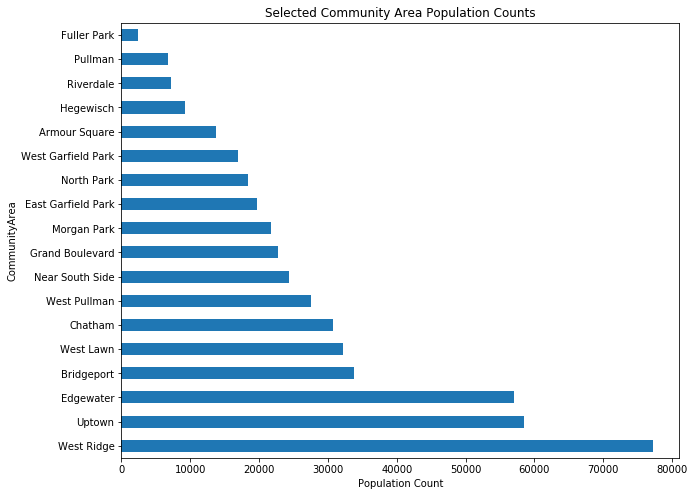

In [98]:
#Let's view the bar graph of the candidates
df_candidates_ordered2 = df_candidates_ordered.set_index('CommunityArea')
ax_final = df_candidates_ordered2['Population'].plot.barh(rot=0, figsize=(10,8))
ax_final.set_xlabel("Population Count")
ax_final.set_title("Selected Community Area Population Counts")

In [101]:
#Final map view of the candidates and locations

#define parameters
latitude2 = df_candidates_ordered['Latitude'].mean(axis=0, skipna=True)
longitude2 = df_candidates_ordered['Longitude'].mean(axis=0, skipna=True)
cluster_map2 = folium.Map(location=[latitude, longitude], zoom_start=11)

#Run a loop to obtain colors and labels
for lat, lng, cluster, neighborhood, ca, pop in zip(df_candidates_ordered['Latitude'], df_candidates_ordered['Longitude'], df_candidates_ordered['Clusters'], df_candidates_ordered['Neighborhood'], df_candidates_ordered['CommunityArea'], df_candidates_ordered['Population']):
    info = 'Cluster {}, {}, {}, {} total population'.format(cluster, neighborhood, ca, pop)
    label = folium.Popup(info, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup = label, color=cluster_color[cluster-1], fill=True, fill_color=cluster_color[cluster-1], fill_opacity=0.5).add_to(cluster_map2)

cluster_map2

### 4. Results
--------

Starting with the largest population count, the community area of Lake View has the largest population in general with 100547, as well as the largest non-senior population. Within the top ten community areas with the highest populations, the populations with the largest senior population included Austin, Near North Side, West Ridge and Portage Park. The community area in tenth place was home to over 60,000 individuals. 

From our venues query, The Loop presented the largest number of venues within a 500 meters. Riverdale and South Deering had no venues within a 500 meter radius. Upon expanding the search radius to 1000 meters, Riverdale and South Deering produced venues, but only a small amount.

The clusters from the k-means produced interesting results. Cluster 2 contained many areas which had popular venues involving transportation, such as train stations, intersections, or bus stops. Cluster 2 also contained the only community area with a Korean restaurant, North Park. Cluster 3 held mainly Mexican Restaurants as the 1st venue picks. Cluster 4 contained areas with popular fast food restaurants. This cluster could have been more accurate if it contained several areas in Cluster 2, such as Calumet Heights, Douglas and North Lawndale. Clusters with single areas included 0, 5, 6, 7, and 8. Clusters 6 and 7 are both well known for their BBQ joints. Cluster 9 presented a variety of locations which usually had a Mexican or fast food restaurant in either the 1st or 2nd venue spot.

Selecting areas which contained Korean, Chinese, Japanese, Vietnamese, Asian, Indian, or Pakistani restaurants yielded the following areas: North Park, Armour Square, Bridgeport, Chatham, Near South Side, Hegewisch, Uptown, West Lawn, Edgewater, West Ridge. Searching for community areas with train, bus or taxi stops yielded the following: East Garfield Park, Fuller Park, Pullman, West Garfield Park, Riverdale, Grand Boulevard, North Park, & Morgan Park.

From the folium maps, distinct divisions can be seen among some areas. Cluster 1, represented in purple ran along the Kennedy Expressway, but was localized to the north side of the city. Cluster 2, represented by dark blue, ran along the Kennedy Expressway, but was mainly on the south side of the city. Cluster 9, represented by red-orange was mainly towards the inner west side of Chicago. Clusters 3 and 4 represented by tints of blue were also located mainly towards the left side of the expressway. Clusters 5, 6 and 8 were all located near the southernmost side of the city. 

Upon further examination, community areas with train stations or bus stops were not within the top 10 most populated areas. In fact, community areas with train stations or intersections were the least populated areas. 

Assuming 60,000 population is the cut off for community area population to be within the top ten, only West Ridge qualifies. Edgewater and Uptown are just below with 57022 and 58424 population respectively. 

### 5. Conclusion
------------

###### 5.1 Recommendations

Overall, my recommendations for setting up a Korean restaurant would be in the community areas of West Ridge, Uptown or Edgewater. My top choice would be West Ridge. Despite the most popular venues being Indian and Pakistani restaurants, it holds the sixth largest population and is nearby North Park, which has a Korean restaurant as one of its top venues. Being near established Asian restaurants will draw in customers who are familiar with or seeking Asian cuisine. Neighborhoods in West Ridge include Nortown, Peterson Park, Rosehill, West Ridge, & West Rogers Park. 

Uptown is my second choice due to being further away from a community area with a well known Korean restaurant, but having popular Vietnamese and Chinese restaurants. Edgewater has a popular Asian restaurant as a venue, but slightly less total population compared to Uptown, so it is my third choice.


###### 5.2 Observations

The Loop held one of the highest venue counts. It easily had 100 venues nearby within 500 meters. According to [the wikipedia page on The Loop](https://en.wikipedia.org/wiki/Chicago_Loop), this makes sense since The Loop is a bustling business district. South Deering and Riverdale both produced no venues when searching within 500 meters, but they produced results once the radius was expanded over that range. Even at 1000 meters, only 2 to 4 venues were nearby. It is safe to assume these areas are located towards the edges of the city.

Cluster 4 contained areas with popular fast food restaurants. This cluster could have been more accurate if it contained several areas in Cluster 2, such as Calumet Heights, Douglas and North Lawndale. Clusters 6 and 7 both held BBQ joints as one of their top venues; however Cluster 6 was located to the outer edges of Chicago, near Beverly and Cluster 7 was located near the center, east of Chicago. Objective popularity may be debatable due to the neighborhood disparity and population difference of nearly 15,000. 


##### 5.3 Limitations
The first limitation is the use of community areas, which incorporate multiple neighborhoods. Due to the malleable boundaries of individual neighborhoods, community areas were used. Further investigation into specific neighborhoods should be performed for accuracy. Second, the population data used is possibly outdated by a few years. The latest census data for 2020 is not available; however once it is, it would provide a more accurate view of demographics. Third, the venues yield from the Foursquare API may change over time. This would most likely yield different results from the ones shown here. 


